## load dependencies

In [ ]:
!pip install -r requirements.txt
!pip install -e .

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from PIL import Image
from diffusion_from_scratch.train import DiffusionModel
reverse_xfrm = DiffusionModel.get_reverse_transform()

def image_grid(img_tensors, rows, cols):
    imgs = [reverse_xfrm(tens) for tens in img_tensors]
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## view (linear) noise schedule

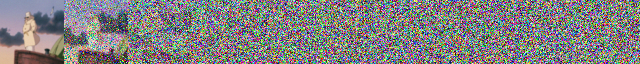

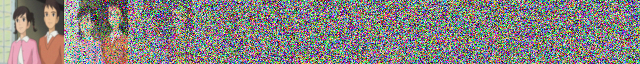

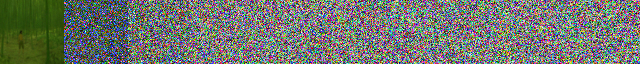

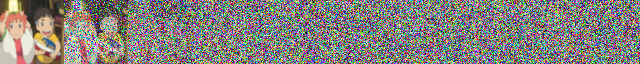

In [47]:
num_imgs = 4
timesteps = range(0, 1000, 100)

# get torch tensor for imgs
dm = DiffusionModel(t_steps=1000, epochs=100, dataset_path="data/miyazaki")
x, _ = next(iter(dm.get_data()))
x = x[:num_imgs, :, :, :].to("cuda")    

# we want x_noisies, a list of tensors (BxCxWxH), one for each timestep
time_to_tensor = lambda t: (torch.ones(num_imgs) * t).long().to(dm.device)
x_noisies = [dm.add_noise_one_step(x, time_to_tensor(timestep))[0] for timestep in timesteps]    

# plot one row for each image
for i in range(num_imgs):
    grid = image_grid(
        [x_noisy[i, :, :, :].detach() for x_noisy in x_noisies],
        rows=1,
        cols=len(x_noisies)
    )
    grid.show()    

can pretty cleary see the rational for different noise schedule

## train and save model
unet from https://github.com/dome272/Diffusion-Models-pytorch/blob/main/modules.py

(but with no attention)

In [ ]:
dm = DiffusionModel(t_steps=1000, epochs=100, dataset_path="data/miyazaki")
model = dm.train_diffusion_model()
torch.save(model.state_dict(), "data/model_ckpt.pt")

epoch 0 iters 73
train loss: 30.59979021549225
val loss: 30.59979021549225
epoch 1 iters 73
train loss: 7.31860888004303
val loss: 7.31860888004303
epoch 2 iters 73
train loss: 6.328887484967709
val loss: 6.328887484967709
epoch 3 iters 73
train loss: 4.993123983964324
val loss: 4.993123983964324
epoch 4 iters 73
train loss: 4.150268690660596
val loss: 4.150268690660596
epoch 5 iters 73
train loss: 3.633218787610531
val loss: 3.633218787610531
epoch 6 iters 73
train loss: 3.0676508164033294
val loss: 3.0676508164033294
epoch 7 iters 73
train loss: 3.312746458686888
val loss: 3.312746458686888
epoch 8 iters 73
train loss: 3.0919870110228658
val loss: 3.0919870110228658
epoch 9 iters 73
train loss: 3.114902788773179
val loss: 3.114902788773179


## results

999it [00:17, 57.53it/s]


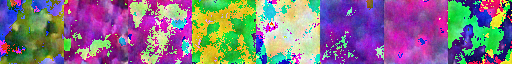

In [52]:
# produce a set of random images
x = torch.randn((8, 3, 64, 64)).to("cuda")
x_denoised = dm.denoise_fully(x, steps=1000)
grid = image_grid(x_denoised, rows=1, cols=len(x_denoised))
grid

## add attention at res 16 level

In [ ]:
dm = DiffusionModel(t_steps=200, epochs=20, dataset_path="data/miyazaki")
model = dm.train_diffusion_model()
torch.save(model.state_dict(), "data/model_ckpt.pt")

199it [00:03, 55.47it/s]


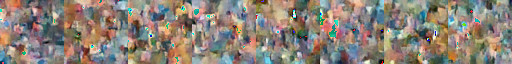

In [54]:
# produce a set of random images
x = torch.randn((8, 3, 64, 64)).to("cuda")
x_denoised = dm.denoise_fully(x, steps=200)
grid = image_grid(x_denoised, rows=1, cols=len(x_denoised))
grid

## train and save model

unet from https://github.com/dome272/Diffusion-Models-pytorch/blob/main/modules.py

In [ ]:
from diffusion_from_scratch.unet_hf import UncondUNet
dm = DiffusionModel(t_steps=500, epochs=50, dataset_path="data/miyazaki", model=UncondUNet(64))
model = dm.train_diffusion_model()
torch.save(model.state_dict(), "data/model_ckpt.pt")

## train and save model

unet from https://huggingface.co/blog/annotated-diffusion

In [ ]:
dm = DiffusionModel(t_steps=200, epochs=100, dataset_path="data/miyazaki")
model = dm.train_diffusion_model()
torch.save(model.state_dict(), "data/model_ckpt.pt")

## load saved models

### from this guy
https://github.com/dome272/Diffusion-Models-pytorch

In [30]:
# load saved model
from diffusion_from_scratch.unet import UncondUNet
model = UncondUNet()
model.load_state_dict(torch.load("data/model_ckpt.pt"))
dm = DiffusionModel(t_steps=200, dataset_path="data/miyazaki", model=model)

199it [00:07, 27.78it/s]


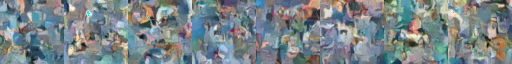

In [31]:
# produce a set of random images
x = torch.randn((8, 3, 64, 64)).to("cuda")
x_denoised = dm.denoise_fully(x, steps=200)
grid = image_grid(x_denoised, rows=1, cols=len(x_denoised))
grid

### from huggingface blog
https://huggingface.co/blog/annotated-diffusion

In [26]:
# load saved model
from diffusion_from_scratch.unet_hf import UncondUNet
model = UncondUNet(64)
model.load_state_dict(torch.load("data/model_new_t500_e50.pt"))
dm = DiffusionModel(t_steps=500, dataset_path="data/miyazaki", model=model)

499it [00:18, 27.21it/s]


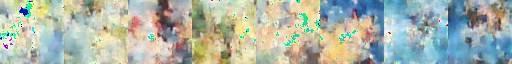

In [27]:
# produce a set of random images
x = torch.randn((8, 3, 64, 64)).to("cuda")
x_denoised = dm.denoise_fully(x, steps=500)
grid = image_grid(x_denoised, rows=1, cols=len(x_denoised))
grid

### model summary
ref: https://github.com/dome272/Diffusion-Models-pytorch

In [34]:
from torchsummary import summary
summary(dm.model)

Layer (type:depth-idx)                                  Param #
├─DoubleConv: 1-1                                       --
|    └─Sequential: 2-1                                  --
|    |    └─Conv2d: 3-1                                 1,728
|    |    └─GroupNorm: 3-2                              128
|    |    └─GELU: 3-3                                   --
|    |    └─Conv2d: 3-4                                 36,864
|    |    └─GroupNorm: 3-5                              128
├─Down: 1-2                                             --
|    └─Sequential: 2-2                                  --
|    |    └─MaxPool2d: 3-6                              --
|    |    └─DoubleConv: 3-7                             73,984
|    |    └─DoubleConv: 3-8                             221,696
|    └─Sequential: 2-3                                  --
|    |    └─SiLU: 3-9                                   --
|    |    └─Linear: 3-10                                16,512
├─SelfAttention: 1-3         

Layer (type:depth-idx)                                  Param #
├─DoubleConv: 1-1                                       --
|    └─Sequential: 2-1                                  --
|    |    └─Conv2d: 3-1                                 1,728
|    |    └─GroupNorm: 3-2                              128
|    |    └─GELU: 3-3                                   --
|    |    └─Conv2d: 3-4                                 36,864
|    |    └─GroupNorm: 3-5                              128
├─Down: 1-2                                             --
|    └─Sequential: 2-2                                  --
|    |    └─MaxPool2d: 3-6                              --
|    |    └─DoubleConv: 3-7                             73,984
|    |    └─DoubleConv: 3-8                             221,696
|    └─Sequential: 2-3                                  --
|    |    └─SiLU: 3-9                                   --
|    |    └─Linear: 3-10                                16,512
├─SelfAttention: 1-3         